# Convolutional autoencoder on STFT data

Taken from https://github.com/pkmital/tensorflow_tutorials/blob/master/python/08_denoising_autoencoder.py


In [3]:
from __future__ import division, print_function, absolute_import
%pylab inline
import wget

import tensorflow as tf
import numpy as np
import os
from utils import *


Populating the interactive namespace from numpy and matplotlib


In [4]:
path = "../wavs/"
fname = 'Stockhausen_Kontakte.wav'
fname = 'mipais.wav'

filename = path+fname
abs
fs,x = wav2audio_segment(filename,10,100)
S = audio2spectral(x,orig_fs=fs,resample_fs=22050,representation='CQT',units='db',nfft_size= 2**10,
         frame_size=64, n_bins = 84,normalization_axis=None)

Dimensions: data length, freq bins, time bins
120 84 64


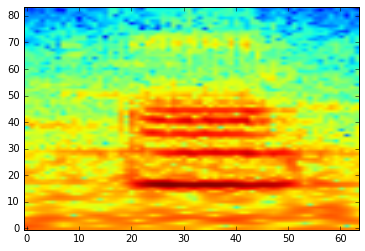

In [7]:
print("Dimensions: data length, freq bins, time bins")
batch_length, freq_bins,time_bins = S.shape
print(batch_length, freq_bins,time_bins)

imshow(S[21],aspect='auto',origin='bottom');

In [8]:
data = Data( S )

In [9]:
batch_size = 64
n_epochs = 100
learning_rate = 0.001
n_filters=[1, 10, 10, 10]
input_shape = [None, int(data.data.shape[1]), int(data.data.shape[2])]
filter_sizes = [1,3,3,1]

In [10]:
input_shape

[None, 84, 64]

In [6]:
def autoencoder(input_shape=[None, 784],
                n_filters=[1, 10, 10, 10],
                filter_sizes=[3, 3, 3, 3]):
    """Build a deep denoising autoencoder w/ tied weights.
    Parameters
    ----------
    input_shape : list, optional
        Description
    n_filters : list, optional
        Description
    filter_sizes : list, optional
        Description
    Returns
    -------
    x : Tensor
        Input placeholder to the network
    z : Tensor
        Inner-most latent representation
    y : Tensor
        Output reconstruction of the input
    cost : Tensor
        Overall cost to use for training
    Raises
    ------
    ValueError
        Description
    """
    # %%
    # input to the network
    x = tf.placeholder( tf.float32, input_shape, name='x')

    x_tensor = tf.reshape( x, [-1, input_shape[1], input_shape[2], n_filters[0]])
    # %%

        
    current_input = x_tensor

    # %%
    # Build the encoder
    encoder = []
    shapes = []
    for layer_i, n_output in enumerate(n_filters[1:]):
        n_input = current_input.get_shape().as_list()[3]
        
        shapes.append(current_input.get_shape().as_list())
        
        W = tf.Variable(
            tf.random_uniform([
                filter_sizes[layer_i],
                filter_sizes[layer_i],
                n_input, n_output],
                -1.0 / math.sqrt(n_input),
                1.0 / math.sqrt(n_input)))
        
        b = tf.Variable(tf.zeros([n_output]))
        
        encoder.append(W)
        
        output = lrelu(
            tf.add(tf.nn.conv2d(
                current_input, W, strides=[1, 2, 2, 1], padding='SAME'), b))
        
        current_input = output

    # %%
    # store the latent representation
    z = current_input
    encoder.reverse()
    shapes.reverse()

    # %%
    # Build the decoder using the same weights
    for layer_i, shape in enumerate(shapes):
        W = encoder[layer_i]
        b = tf.Variable(tf.zeros([W.get_shape().as_list()[2]]))
        output = lrelu(tf.add(
            tf.nn.conv2d_transpose(
                current_input, W,
                tf.pack([tf.shape(x)[0], shape[1], shape[2], shape[3]]),
                strides=[1, 2, 2, 1], padding='SAME'), b))
        current_input = output

    # %%
    # now have the reconstruction through the network
    y = current_input
    # cost function measures pixel-wise difference
    cost = tf.reduce_mean(tf.square(y - x_tensor))

    # %%
    return {'x': x, 'z': z, 'y': y, 'cost': cost}
# %%

ae = autoencoder(input_shape=input_shape, n_filters=n_filters, filter_sizes=filter_sizes)

# %%

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(ae['cost'])

# %%
# We create a session to use the graph
sess = tf.Session()
sess.run(tf.initialize_all_variables())

# %%
# Fit all training data

total_batch = int(data.length/batch_size)
for epoch_i in range(n_epochs):
    for batch_i in range(total_batch):
        batch_xs = data.next_batch(batch_size)

        sess.run(optimizer, feed_dict={
            ae['x']: batch_xs })
    
    if epoch_i%5==0:
        print(epoch_i, sess.run(ae['cost'], feed_dict={ae['x']: batch_xs}))

0 0.0116451
5 0.0107691
10 0.0101015
15 0.0100154
20 0.00956548
25 0.00928068
30 0.00886504
35 0.00915376
40 0.00912701
45 0.00919043
50 0.00892407
55 0.00920893
60 0.00892608
65 0.00900236
70 0.00885549
75 0.0091206
80 0.00898639
85 0.00902859
90 0.00891849
95 0.0087235


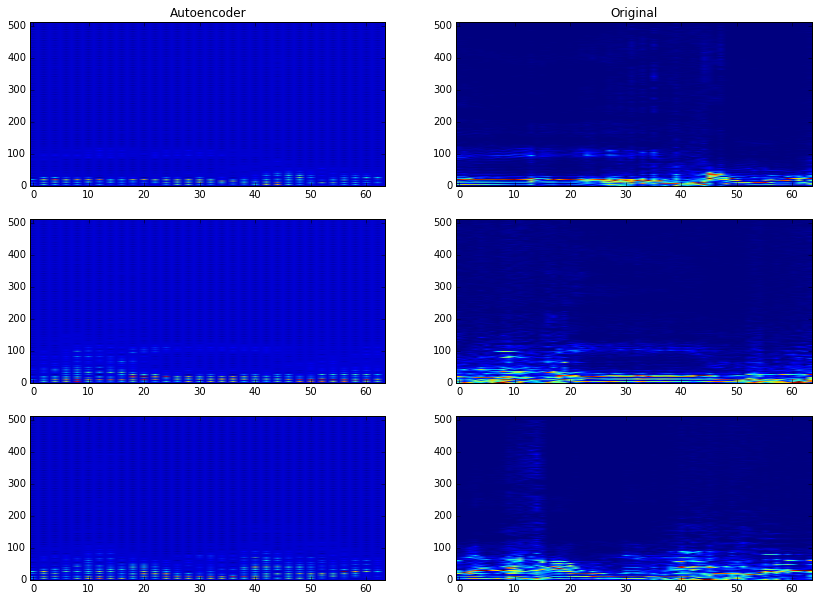

In [7]:
compare = [3,21,46]

recon = sess.run(ae['y'], feed_dict={ ae['x']: data.data[compare]})

original = data.data[compare]
figure(figsize=(14,10))
for i,c in enumerate(compare):
    
    subplot(len(compare),2,i*2+1)
    imshow(recon[i].reshape((freq_bins,time_bins)),aspect='auto',origin='bottom')
    subplot(len(compare),2,i*2+2)
    imshow(original[i].reshape((freq_bins,time_bins)),aspect='auto',origin='bottom')

subplot(len(compare),2,1)
title("Autoencoder")
subplot(len(compare),2,2)
title("Original")

# savefig("results_cqt_dim_"+str(dimensions)+"_cost_"+"{:.4f}.png".format(cost_value))

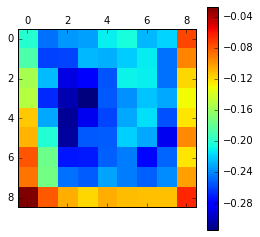

In [66]:
recon = sess.run(ae['z'], feed_dict={ ae['x']: data.data[21:22]})
matshow(recon[0,:,:,0])
colorbar()

In [54]:
recon.shape

(1, 9, 9, 10)

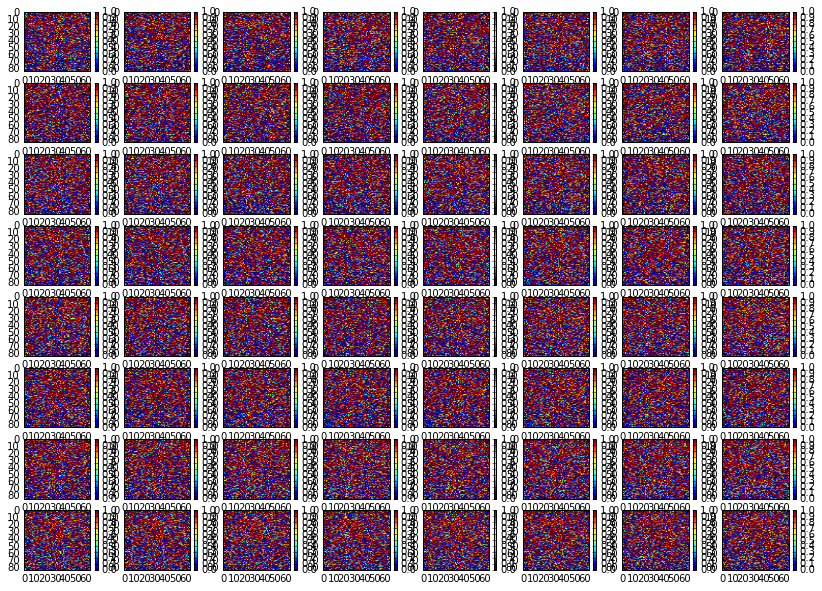

In [66]:
Y = np.zeros((1,dimensions[-1]),dtype=np.float32)
figure(figsize=(14,10))
for i in range(dimensions[-1]):
    Y[0,i] = 1
    out = sess.run(decoder(Y), feed_dict={X: data.data[3:4]})
    subplot(dimensions[-1]/8,8,i+1)
    imshow(out.reshape((freq_bins,time_bins)),aspect='auto')
    colorbar()

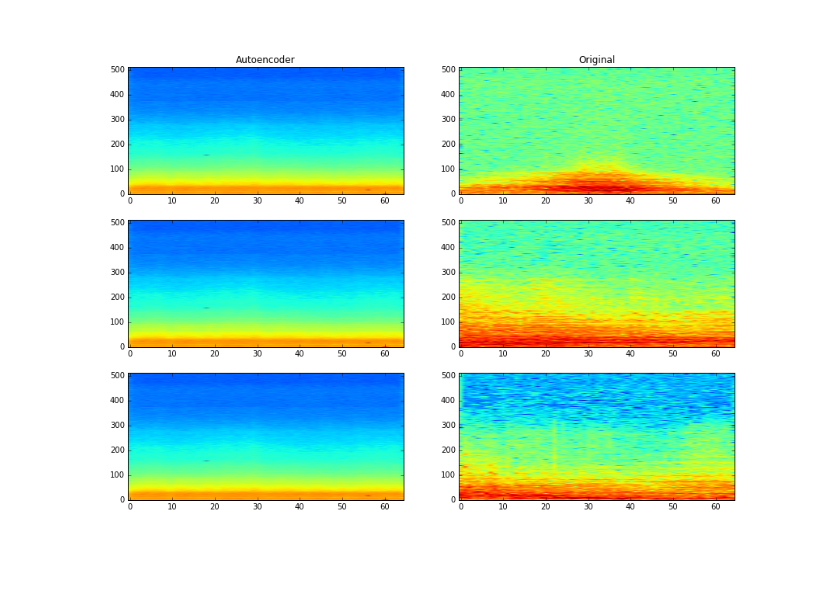

In [21]:
I = imread("results_dim_[256, 64]_cost_0.0082.png")
figure(figsize=(14,10))
imshow(I)
plt.axis('off');